In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [36]:
df = web.DataReader('TSLA', data_source= 'yahoo', start='2012-01-01', end='2019-12-17')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,1.966667,1.843333,1.929333,1.872000,13921500,1.872000
2012-01-04,1.911333,1.833333,1.880667,1.847333,9451500,1.847333
2012-01-05,1.862000,1.790000,1.850667,1.808000,15082500,1.808000
2012-01-06,1.852667,1.760667,1.813333,1.794000,14794500,1.794000
2012-01-09,1.832667,1.741333,1.800000,1.816667,13455000,1.816667
...,...,...,...,...,...,...
2019-12-11,23.812668,23.406000,23.458668,23.513332,103467000,23.513332
2019-12-12,24.182667,23.548668,23.661333,23.978666,116458500,23.978666
2019-12-13,24.347334,23.642668,24.070000,23.892668,98563500,23.892668


In [37]:
df.shape

(2003, 6)

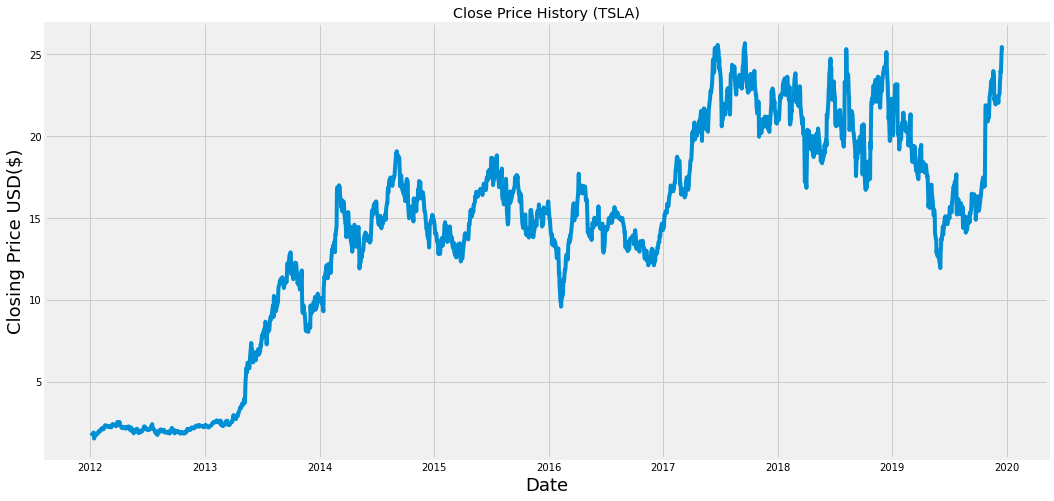

In [38]:
plt.figure(figsize=(16,8))
plt.title('Close Price History (TSLA)')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD($)', fontsize=18)
plt.show()

In [39]:
data = df.filter(['Close'])
# Convert into a numpy array
dataset = data.values
len_train_data = math.ceil(len(dataset) * 0.8)
len_train_data

1603

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0146048 ],
       [0.01358328],
       [0.0119544 ],
       ...,
       [0.92653433],
       [0.99033701],
       [0.98340739]])

In [41]:
train_data = scaled_data[0: len_train_data, :]
# Split into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])


In [42]:
# Convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [43]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1543, 60, 1)

In [44]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [45]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [46]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

1543/1543 [==============================] - 113s 70ms/step - loss: 0.0023


In [47]:
test_data = scaled_data[len_train_data - 60: , :]

X_test = []
y_test = dataset[len_train_data:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])

In [48]:
#Convert data into numpy array
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [49]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

13/13 [==============================] - 2s 26ms/step


In [50]:
# Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test)** 2)
rmse

0.2975874757766724

C:\Users\William\AppData\Local\Temp\ipykernel_16864\1182801711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


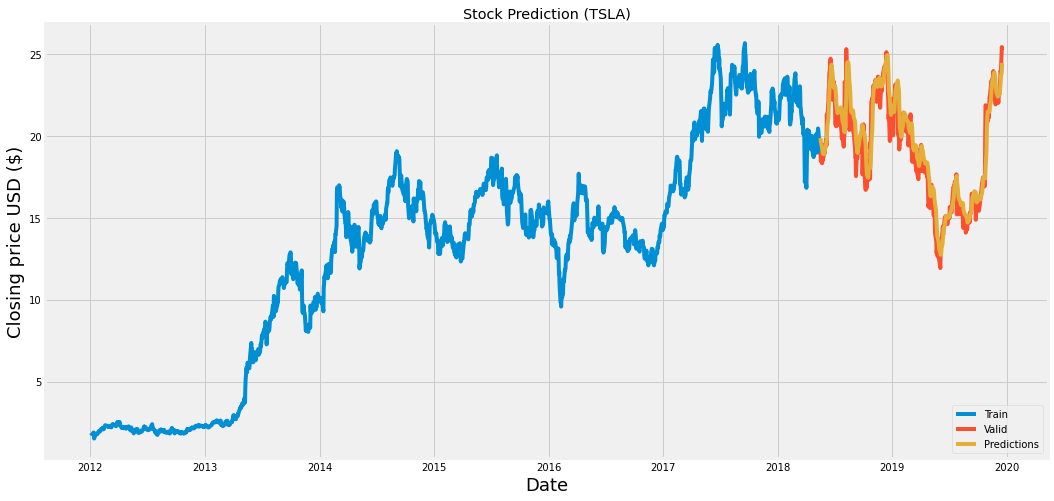

In [51]:
# Plot result
train = data[:len_train_data]
valid = data[len_train_data:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Stock Prediction (TSLA)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()